In [1]:
import os
import sys
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
from tensorflow import keras 
warnings.filterwarnings("ignore")
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [2]:
sys.path.append(os.path.join(os.path.dirname(os.path.dirname(os.getcwd())),'python-packages/'))
from deep_hashing_models import *
from similarities import *
from lsh_search import *

# 1. Data Preparation

In [3]:
data_repo = os.path.join(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))),'data/')

In [4]:
df_distinct_stacks = pd.read_csv(data_repo + 'frequent_stack_traces.csv', index_col = [0])
df_measures = pd.read_csv(data_repo + 'similarity-measures-pairs.csv', index_col = [0])

In [5]:
n_stacks = df_distinct_stacks.shape[0]
n_stacks

1000

In [6]:
vectorizer_bag_of_frames = CountVectorizer(token_pattern = r"(?u)\b[a-zA-Z0-9_.]{2,}\b")
s = df_distinct_stacks['stackTraceCusto'].apply(lambda x : x.replace('\n',' '))
s = s.apply(lambda x : x.replace('$',''))
s = s.apply(lambda x : x.replace('/',''))
s = s.apply(lambda x : x.replace('<',''))
s = s.apply(lambda x : x.replace('>',''))
X_bag_of_frames = vectorizer_bag_of_frames.fit_transform(list(s)).toarray()
df_bag_of_frames = pd.DataFrame(data = X_bag_of_frames, columns = vectorizer_bag_of_frames.get_feature_names())

In [7]:
X_train, X_validation, Y_train, Y_validation = train_test_split(df_measures.index, df_measures['Cosine'], test_size = 0.2) 

In [8]:
indexes_train_1 = X_train.to_series().apply(lambda x : get_two_indexes(x, df_distinct_stacks.shape[0])[0]).to_list()
indexes_train_2 = X_train.to_series().apply(lambda x : get_two_indexes(x, df_distinct_stacks.shape[0])[1]).to_list()
indexes_validation_1 = X_validation.to_series().apply(lambda x : get_two_indexes(x, df_distinct_stacks.shape[0])[0]).to_list()
indexes_validation_2 = X_validation.to_series().apply(lambda x : get_two_indexes(x, df_distinct_stacks.shape[0])[1]).to_list()

In [9]:
X_train = dict()
X_train['stack_1'] = df_bag_of_frames.loc[indexes_train_1].values
X_train['stack_2'] = df_bag_of_frames.loc[indexes_train_2].values

X_validation = dict()
X_validation['stack_1'] = df_bag_of_frames.loc[indexes_validation_1].values
X_validation['stack_2'] = df_bag_of_frames.loc[indexes_validation_2].values

In [10]:
Y_train = Y_train.values
Y_validation = Y_validation.values

In [11]:
assert X_train['stack_1'].shape == X_train['stack_2'].shape
assert len(X_train['stack_1']) == len(Y_train)

### Distribution of training data

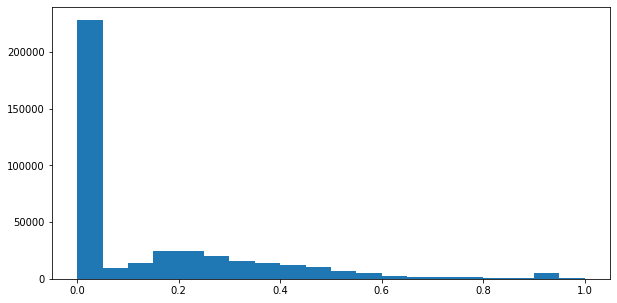

In [12]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.hist(Y_train, 20, alpha = 1, density = False)
plt.show()

### Distribution of test data

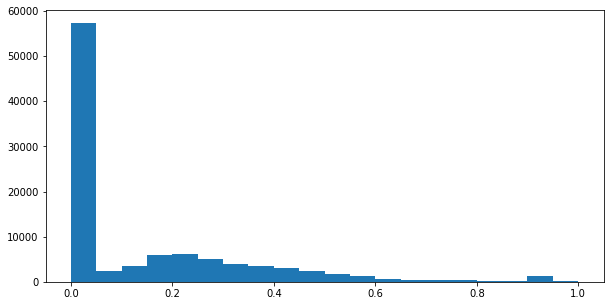

In [13]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.hist(Y_validation, 20, alpha = 1, density = False)
plt.show()

# 2. Model Design

In [8]:
'Number of hash tables functions' 
m = 64

In [9]:
'Number of bits per hash function' 
b = 8

In [10]:
'Size hash vector'
size_hash_vector = m * b
size_hash_vector

512

## 2.1. Feature learning phase

In [17]:
x = Sequential()
x.add(Dense(2048, input_dim = X_train['stack_1'].shape[1], activation = 'tanh'))
x.add(Dense(1024, activation = 'tanh'))
x.add(Dense(size_hash_vector, activation = 'tanh'))
shared_model = x

## 2.2. Siamese Model 

In [18]:
input_shape = (X_train['stack_1'].shape[1],)
model = siamese_model_baseline(shared_model, input_shape, is_sparse = True, print_summary = True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2244)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2244)]       0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 512)          7220736     input_1[0][0]                    
                                                                 input_2[0][0]                    
                                                                 input_1[0][0]                    
                                                                 input_2[0][0]                

## 2.3. Model training 

In [19]:
siamese_model = train_siamese_model_baseline(model, X_train, X_validation, Y_train, Y_validation, size_hash_vector, batch_size = 512, epochs = 20)

Epoch 1/20
781/781 [==============================] - 16s 19ms/step - loss: -0.2430 - manh_dist_loss: 0.0075 - abs_vect_loss: -0.9942 - abs_vect_1_loss: -0.9944 - manh_dist_rmse: 0.0866 - manh_dist_mae: 0.0624 - val_loss: -0.2453 - val_manh_dist_loss: 0.0057 - val_abs_vect_loss: -0.9983 - val_abs_vect_1_loss: -0.9985 - val_manh_dist_rmse: 0.0755 - val_manh_dist_mae: 0.0577
Epoch 2/20
781/781 [==============================] - 14s 18ms/step - loss: -0.2455 - manh_dist_loss: 0.0056 - abs_vect_loss: -0.9987 - abs_vect_1_loss: -0.9988 - manh_dist_rmse: 0.0746 - manh_dist_mae: 0.0571 - val_loss: -0.2457 - val_manh_dist_loss: 0.0054 - val_abs_vect_loss: -0.9988 - val_abs_vect_1_loss: -0.9989 - val_manh_dist_rmse: 0.0736 - val_manh_dist_mae: 0.0565
Epoch 3/20
781/781 [==============================] - 14s 18ms/step - loss: -0.2458 - manh_dist_loss: 0.0053 - abs_vect_loss: -0.9990 - abs_vect_1_loss: -0.9990 - manh_dist_rmse: 0.0729 - manh_dist_mae: 0.0562 - val_loss: -0.2458 - val_manh_dist_lo

# 3. Model Evaluation

In [20]:
model.layers

## 3.1. Loss functions

#### 3.1.1. MSE of $\mathcal{L}_{CNNH+LSH}$

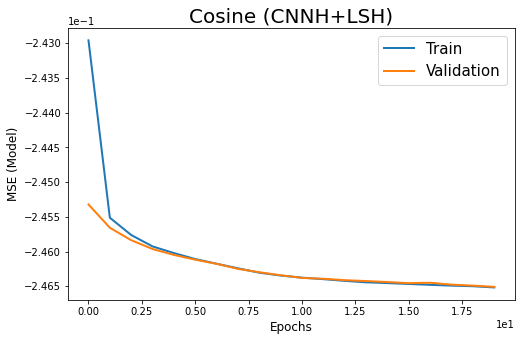

In [21]:
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(siamese_model.history['loss'], linewidth = 2)
plt.plot(siamese_model.history['val_loss'], linewidth = 2)
plt.title('Cosine (CNNH+LSH)', fontsize = 20)
plt.ylabel('MSE (Model)', fontsize = 12)
plt.xlabel('Epochs', fontsize = 12)
plt.ticklabel_format(style='', scilimits=(0,0))
plt.legend(['Train', 'Validation'], loc='upper right', fontsize=15)

#### 3.1.2. RMSE of LSH preserving loss

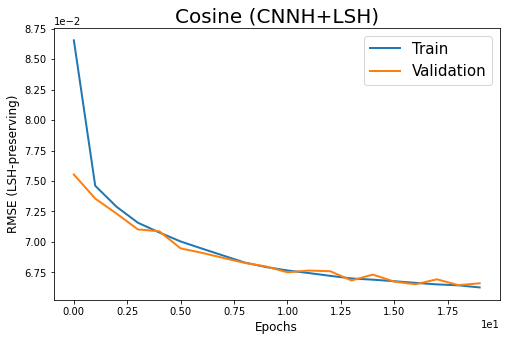

In [22]:
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(siamese_model.history[model.layers[3].name + '_rmse'], linewidth = 2)
plt.plot(siamese_model.history['val_' + model.layers[3].name + '_rmse'], linewidth = 2)
plt.title('Cosine (CNNH+LSH)', fontsize = 20)
plt.ylabel('RMSE (LSH-preserving)', fontsize = 12)
plt.xlabel('Epochs', fontsize = 12)
plt.ticklabel_format(style='', scilimits=(0,0))
plt.legend(['Train', 'Validation'], loc='upper right', fontsize=15)

#### 3.1.3. MAE of LSH preserving loss

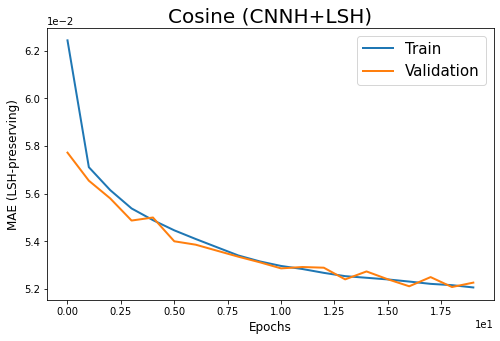

In [23]:
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(siamese_model.history[model.layers[3].name + '_mae'], linewidth = 2)
plt.plot(siamese_model.history['val_' + model.layers[3].name + '_mae'], linewidth = 2)
plt.title('Cosine (CNNH+LSH)', fontsize = 20)
plt.ylabel('MAE (LSH-preserving)', fontsize = 12)
plt.xlabel('Epochs', fontsize = 12)
plt.ticklabel_format(style='', scilimits=(0,0))
plt.legend(['Train', 'Validation'], loc='upper right', fontsize=15)

## 3.2. Model Predictions

In [24]:
predictions = predict(model, X_validation)

### 3.2.1. Examples

In [25]:
np.around(predictions[0][:50],3) 

array([0.224, 0.022, 0.056, 0.113, 0.147, 0.144, 0.113, 0.073, 0.138,
       0.069, 0.252, 0.016, 0.031, 0.978, 0.024, 0.144, 0.021, 0.047,
       0.054, 0.124, 0.249, 0.086, 0.368, 0.132, 0.863, 0.09 , 0.284,
       0.326, 0.046, 0.143, 0.048, 0.035, 0.4  , 0.03 , 0.256, 0.148,
       0.272, 0.052, 0.052, 0.023, 0.134, 0.316, 0.043, 0.021, 0.063,
       0.018, 0.384, 0.047, 0.039, 0.014], dtype=float32)

In [26]:
np.around(Y_validation[:50],3) 

array([0.277, 0.   , 0.   , 0.2  , 0.198, 0.   , 0.   , 0.   , 0.069,
       0.   , 0.24 , 0.   , 0.   , 0.946, 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.258, 0.164, 0.38 , 0.176, 0.669, 0.118, 0.218,
       0.35 , 0.   , 0.211, 0.   , 0.   , 0.347, 0.   , 0.308, 0.118,
       0.274, 0.   , 0.   , 0.   , 0.193, 0.284, 0.   , 0.   , 0.045,
       0.   , 0.345, 0.   , 0.   , 0.   ])

### 3.2.2. Spearman $\rho$ and Kendall $\tau$ correlation

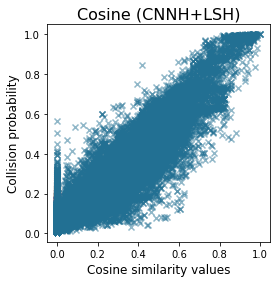

In [27]:
plt.rcParams["figure.figsize"] = (4,4)
plt.scatter(Y_validation, predictions[0], alpha = 0.5, marker = 'x', c = '#227093')
plt.title('Cosine (CNNH+LSH)', fontsize = 16)
plt.xlabel("Cosine similarity values", fontsize = 12)
plt.ylabel("Collision probability", fontsize = 12)
plt.savefig('Results/Baseline/Cosine-correlation', bbox_inches='tight')
plt.show()

In [28]:
rho, p_value = spearman_rho(predictions, Y_validation)
rho

0.8722699603297017

In [29]:
tau, p_value = kendall_tau(predictions, Y_validation)
tau

0.7371431416606916

## 3.3. Approximate Hamming Evaluation

In [30]:
output_layer = 2
model.layers[output_layer]

In [31]:
intermediate_model = intermediate_model_trained(shared_model, output_layer)

In [32]:
intermediate_model.save('Models/model-baseline.model')

INFO:tensorflow:Assets written to: Models/model-baseline.model/assets


In [13]:
#intermediate_model = keras.models.load_model('Models/model-baseline.model')

### 3.3.1. Example of a hash vector provided by the model (in the last epoch)

In [14]:
intermediate_model.predict(df_bag_of_frames.iloc[[10]])[0][:32]

array([ 0.99998325, -0.9655963 ,  1.        , -0.99986553, -1.        ,
        0.9999338 ,  0.99773264,  0.99999046, -0.9553104 ,  1.        ,
        0.9921656 ,  0.9997034 ,  0.99988633,  1.        ,  0.9946391 ,
       -1.        ,  1.        , -1.        , -0.9998717 , -0.99999964,
        1.        ,  0.9977584 ,  0.9999781 ,  0.9999995 ,  1.        ,
        1.        ,  0.99380714, -1.        , -0.999984  , -0.9994263 ,
        0.99464756,  1.        ], dtype=float32)

### 3.3.2. Average value of the absolute hash values

In [15]:
hash_vectors = intermediate_model.predict(df_bag_of_frames)

In [16]:
np.mean(np.abs(hash_vectors))

0.983729

### 3.3.3. Ratio of binary values from hash vectors provided by the model

In [17]:
hash_vectors[(hash_vectors == 1) | (hash_vectors == -1)].size / hash_vectors.size

0.193482421875

### 3.3.4. Comparison between approximate hamming and real hamming

In [38]:
df_hamming = compare_hamming(X_validation, intermediate_model, b, size_hash_vector)

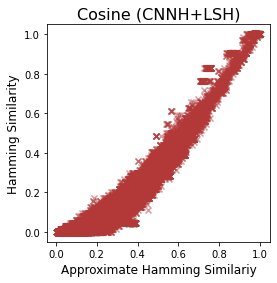

In [39]:
plt.rcParams["figure.figsize"] = (4,4)
plt.scatter(predictions[0], df_hamming['hamming'], alpha = 0.5, marker = 'x', c = '#b33939')
plt.xlabel("Approximate Hamming Similariy", fontsize = 12)
plt.ylabel("Hamming Similarity", fontsize = 12)
plt.title('Cosine (CNNH+LSH)', fontsize = 16)
plt.savefig('Results/Baseline/Cosine-hamming-comparison', bbox_inches='tight')
plt.show()

# 4. Locality Sensitive Hashing

In [18]:
hash_vectors_hamming = convert_to_hamming(hash_vectors)

In [20]:
params = lsh_hyperparams(m)
'(K,L)'
params 

[(1, 64), (2, 32), (4, 16), (8, 8), (16, 4), (32, 2), (64, 1)]

## 4.1. Choose the best combination (L, K)


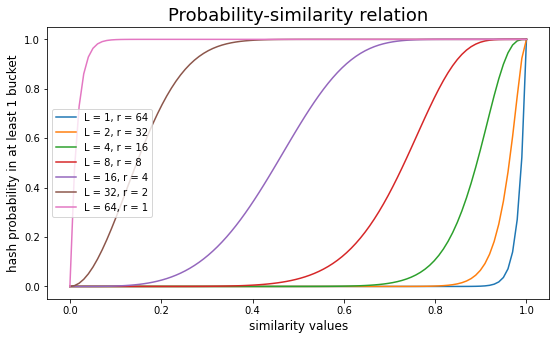

In [42]:
plt.rcParams["figure.figsize"] = [9, 5]
x = np.linspace(0, 1, 100)
for param in params:
    y = 1 - (1 - (x)**param[1])**param[0]
    plt.plot(x, y, label = 'L = %d, r = %d' %param)
plt.xlabel("similarity values", fontsize = 12)
plt.ylabel("hash probability in at least 1 bucket", fontsize = 12)
plt.title('Probability-similarity relation', fontsize = 18)
plt.legend()

In [43]:
df_probLSH = mean_prob_hashing_smallest_elt(n_stacks, params, hash_vectors_hamming, b, df_measures, 'Cosine', trace = False)

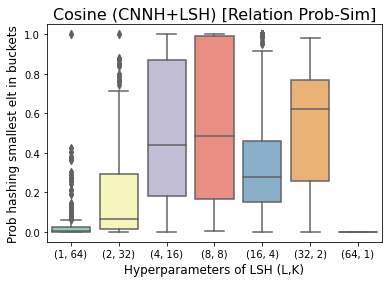

In [44]:
f, ax = plt.subplots(figsize=(6, 4))
ax = sns.boxplot(data = df_probLSH, palette="Set3")
plt.xlabel("Hyperparameters of LSH (L,K)", fontsize = 12)
plt.ylabel("Prob hashing smallest elt in buckets", fontsize = 12)
plt.title('Cosine (CNNH+LSH) [Relation Prob-Sim]', fontsize = 16)
plt.savefig('Results/Baseline/Cosine-Relation-Prob-Sim', bbox_inches='tight')
plt.show()

In [45]:
'Exemple, L = K = 8'
L, K = params[3]
L, K

(8, 8)

In [46]:
df_probLSH.mean()['(4, 16)']

0.49866363666315777

In [47]:
df_probLSH.median()['(4, 16)']

0.4417843171295677

## 4.2. Build hash tables with binary hash vectors w.r.t $K$ and $L$

In [48]:
hash_tables = create_hash_tables(L, K, b, hash_vectors_hamming)

In [49]:
with open('Hash-Tables/hash_tables_baseline.pkl', 'wb') as f:
    pickle.dump(hash_tables, f)

## 4.3. Search for approximate nearest neighbors (this procedure need to be explained in the paper) 

In [50]:
'pointer to the stack trace'
index = random.randint(0,n_stacks)
index

865

In [51]:
set_near_duplicates = near_duplicates(L, K, b, index, hash_vectors_hamming, hash_tables)
set_near_duplicates

{11,
 64,
 82,
 115,
 117,
 187,
 314,
 349,
 389,
 404,
 406,
 474,
 550,
 684,
 700,
 748,
 769,
 775,
 790,
 865,
 879,
 940}

In [52]:
list_near_duplicate_pairs = near_duplicate_pairs(index, set_near_duplicates, n_stacks)
n_duplicate_pairs = len(list_near_duplicate_pairs)

In [53]:
near_duplicates_sim = df_measures['Cosine'][list_near_duplicate_pairs].sort_values(ascending = False)
near_duplicates_sim

398789    0.964286
474389    0.964286
473030    0.947514
467990    0.947514
288440    0.947514
449910    0.947514
265095    0.947514
323837    0.947514
110844    0.947514
79379     0.945611
11787     0.928571
313620    0.909241
490529    0.877328
490468    0.877328
109079    0.857143
62720     0.842235
361815    0.842235
477629    0.800132
454814    0.800132
170099    0.785714
322650    0.741249
Name: Cosine, dtype: float64

In [54]:
set_real_nns, real_nns_sim = real_nns(index, df_measures, 'Cosine', n_stacks, n_duplicate_pairs)
set_real_nns

{11,
 64,
 82,
 115,
 117,
 313,
 314,
 349,
 389,
 406,
 474,
 550,
 665,
 684,
 748,
 769,
 775,
 874,
 879,
 887,
 940}

In [55]:
real_nns_sim[:n_duplicate_pairs]

474389    0.964286
398789    0.964286
449910    0.947514
110844    0.947514
467990    0.947514
265095    0.947514
288440    0.947514
473030    0.947514
323837    0.947514
79379     0.945611
11787     0.928571
313620    0.909241
490468    0.877328
490529    0.877328
109079    0.857143
361815    0.842235
62720     0.842235
490476    0.836502
490463    0.836502
264410    0.836502
443754    0.836502
dtype: float64

## 4.4. Metrics

### 4.4.1. Ratio of finding the $k$ real nearest neighbor with the Least $L$ (Recal rate at $k$ first positions)

In [56]:
'All params'
k_first_positions = 1
recal_rate(n_stacks, params, hash_vectors_hamming, b, df_measures, k_first_positions, 'Cosine')

0.836

In [57]:
'Best param'
k_first_positions = 1
recal_rate_one_param(n_stacks, params[3], hash_vectors_hamming, b, df_measures, k_first_positions, 'Cosine')

0.9414575866188769

-----------------------------------------------------------------

In [58]:
'All params'
k_first_positions = 3
recal_rate(n_stacks, params, hash_vectors_hamming, b, df_measures, k_first_positions, 'Cosine')

0.8346666666666663

In [59]:
'Best param'
k_first_positions = 3
recal_rate_one_param(n_stacks, params[3], hash_vectors_hamming, b, df_measures, k_first_positions, 'Cosine')

0.93037672865999

-----------------------------------------------------------------

In [60]:
'All params'
k_first_positions = 5
recal_rate(n_stacks, params, hash_vectors_hamming, b, df_measures, k_first_positions, 'Cosine')

0.8269999999999996

In [61]:
'Best param'
k_first_positions = 5
recal_rate_one_param(n_stacks, params[3], hash_vectors_hamming, b, df_measures, k_first_positions, 'Cosine')

0.9247524752475249

### 4.4.2. Accuracy of finding the real nearest neighbors (Generalized MRR)

$ \frac{1}{|\mathcal{R}_i|} \sum_{s' \in \mathcal{R}_i} \frac{\text{rank}(s',\mathcal{R}_i)}{\text{rank}(s',NNs(s_i))} $

In [62]:
df_knns = mean_generalized_mrr(n_stacks, params, hash_vectors_hamming, b, df_measures ,'Cosine', trace = True)
df_knns.mean(skipna = True, axis = 0)

(1, 64)
0
100
200
300
400
500
600
700
800
900
-----------------------------
(2, 32)
0
100
200
300
400
500
600
700
800
900
-----------------------------
(4, 16)
0
100
200
300
400
500
600
700
800
900
-----------------------------
(8, 8)
0
100
200
300
400
500
600
700
800
900
-----------------------------
(16, 4)
0
100
200
300
400
500
600
700
800
900
-----------------------------
(32, 2)
0
100
200
300
400
500
600
700
800
900
-----------------------------
(64, 1)
0
100
200
300
400
500
600
700
800
900
-----------------------------


(1, 64)    0.978898
(2, 32)    0.969636
(4, 16)    0.951672
(8, 8)     0.883605
(16, 4)    0.775978
(32, 2)    0.846673
(64, 1)    0.968758
dtype: float64

In [63]:
df_knns.mean(skipna = True, axis = 0)['(4, 16)']

0.9516715636215816

### 4.4.3. Recall w.r.t. LSH

In [21]:
df_recall = recall_all(n_stacks, params, hash_vectors_hamming, b, df_measures ,'Cosine', trace = False)
df_recall.mean(skipna = True)

(1, 64)    1.000000
(2, 32)    0.907983
(4, 16)    0.897849
(8, 8)     0.746252
(16, 4)    0.506899
(32, 2)    0.431548
(64, 1)    0.836325
dtype: float64

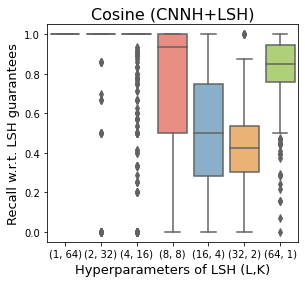

In [22]:
f, ax = plt.subplots(figsize=(4.5, 4))
ax = sns.boxplot(data = df_recall, palette="Set3")
plt.xlabel("Hyperparameters of LSH (L,K)", fontsize = 13)
plt.ylabel("Recall w.r.t. LSH guarantees", fontsize = 13)
plt.title('Cosine (CNNH+LSH)', fontsize = 16)
plt.savefig('Results/Baseline/Recall-LSH', bbox_inches='tight')
plt.show()

### 4.4.4. Precison w.r.t. LSH

In [23]:
df_precision = precision_all(n_stacks, params, hash_vectors_hamming, b, df_measures ,'Cosine', trace = False)
df_precision.mean(skipna = True, axis = 0)

(1, 64)    0.007026
(2, 32)    0.174101
(4, 16)    0.710945
(8, 8)     0.778797
(16, 4)    0.803730
(32, 2)    0.943631
(64, 1)    0.811720
dtype: float64

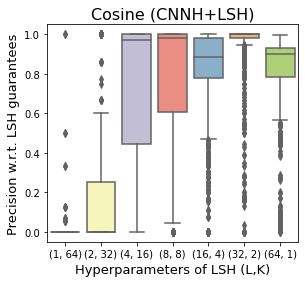

In [24]:
f, ax = plt.subplots(figsize=(4.5, 4))
ax = sns.boxplot(data = df_precision, palette="Set3")
plt.xlabel("Hyperparameters of LSH (L,K)", fontsize = 13)
plt.ylabel("Precision w.r.t. LSH guarantees", fontsize = 13)
plt.title('Cosine (CNNH+LSH)', fontsize = 16)
plt.savefig('Results/Baseline/precision-LSH', bbox_inches='tight')
plt.show()

### 4.4.5. Fscore w.r.t. LSH

In [25]:
df_score_all = fscore_all(df_precision, df_recall)
df_score_all.mean(skipna = True)

(1, 64)    0.009163
(2, 32)    0.209292
(4, 16)    0.700560
(8, 8)     0.684329
(16, 4)    0.565738
(32, 2)    0.568238
(64, 1)    0.800763
dtype: float64

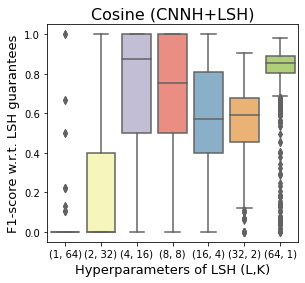

In [26]:
f, ax = plt.subplots(figsize=(4.5, 4))
ax = sns.boxplot(data = df_score_all, palette="Set3")
plt.xlabel("Hyperparameters of LSH (L,K)", fontsize = 13)
plt.ylabel("F1-score w.r.t. LSH guarantees", fontsize = 13)
plt.title('Cosine (CNNH+LSH)', fontsize = 16)
plt.savefig('Results/Baseline/fscore-LSH', bbox_inches='tight')
plt.show()